# I_ss : Steady-state outward K current

## 1.0 Setup

In [1]:
# Import packages and constants
import os
import sys 
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), 'Python File')))

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from constants import  K_i, K_o,g_ss, R, T, F ,E_K

In [2]:
# Add here any state or other calculations that need to be performed before calculating the current
""" D i f f e r e n t i a l  E q u a t i o n s   f r o m   t h e   p a p e r """
# Ca_independent_transient_outward_K_current_s_slow_gate
def dr_ss_dt(t,r_ss_current, V):
    tau_r_ss = 10.0 / 45.16 * np.exp(0.03577 * (V + 50.0)) + 98.9 * np.exp(-0.1 * (V + 38.0))
    r_ss = 1 / (1 + np.exp((V + 11.5) / -11.82))
    return (r_ss - r_ss_current) / tau_r_ss

# Ca_independent_transient_outward_K_current_s_slow_gate
def ds_ss_dt(t,s_ss_current, V):
    tau_s_ss = 2.1
    s_ss = 1 / (1 + np.exp((V + 87.5) / 10.3))
    return (s_ss - s_ss_current) / tau_s_ss

def solve_differential(V,t_eval,t_span): 
    # Initial values got these from the model
    r_ss_0 = 0.002907171
    s_ss_0 = 0.3142767

    # Solving the differential equations
    r_ss_solution = solve_ivp(dr_ss_dt, t_span, [r_ss_0], args=(V,), t_eval=t_eval,  method='RK45')
    s_ss_solution = solve_ivp(ds_ss_dt, t_span, [s_ss_0], args=(V,), t_eval=t_eval,  method='RK45')

    # Extract the final steady-state values
    # ASSUMPTION : final solution is steadystate as its taking incredibly long to run the code 
    r_ss_steady = r_ss_solution.y[0]
    s_ss_steady = s_ss_solution.y[0]

    return r_ss_steady,s_ss_steady

# Create the function to calculate the current
def i_ss_current(V,g_ss,diabetes):
    
    if diabetes:
        g_ss = 0.77 * g_ss

    # Solving differential equations 
    start_time = 0 
    end_time = 1000
    t_eval = np.linspace(start_time, end_time, 4)
    t_span = (start_time,end_time)

    r_ss_sol,s_ss_sol= solve_differential(V,t_eval,t_span)
    r_ss_steady = r_ss_sol[-1]
    s_ss_steady = s_ss_sol[-1]
    

    # Calculating E_K using the Nernst equation
    E_K = R*T/F*np.log(K_o/K_i)

    # Calculating the current 
    i_ss =  g_ss * r_ss_steady * s_ss_steady * (V - E_K)
    return i_ss

## 2.0 Solving

In [3]:
V_range = np.linspace(-60, 60, 40)

### 2.1 Healthy Cell


In [4]:
diabetes = False

# Initialising array to hold the current values 
i_ss_values = []

# Solve for different values of v and calculate I 
for V in V_range:
    i_ss=  i_ss_current(V,g_ss,diabetes)
    i_ss_values.append(i_ss)

### 2.2 Diabetes

In [5]:
diabetes = True

# Initialising array to hold the current values 
i_ss_diabetic_values = []

# Solve for different values of v and calculate I 
for V in V_range:
    i_ss=  i_ss_current(V,g_ss,diabetes)
    i_ss_diabetic_values.append(i_ss)


In [6]:
# Normalising values to get current density
C = 100e-6 #microfarads
normalised_healthy_i_ss = np.array(i_ss_values) * 1e-3 / C
normalised_diabetic_i_ss = np.array(i_ss_diabetic_values) * 1e-3 / C

## 3.0 Plotting

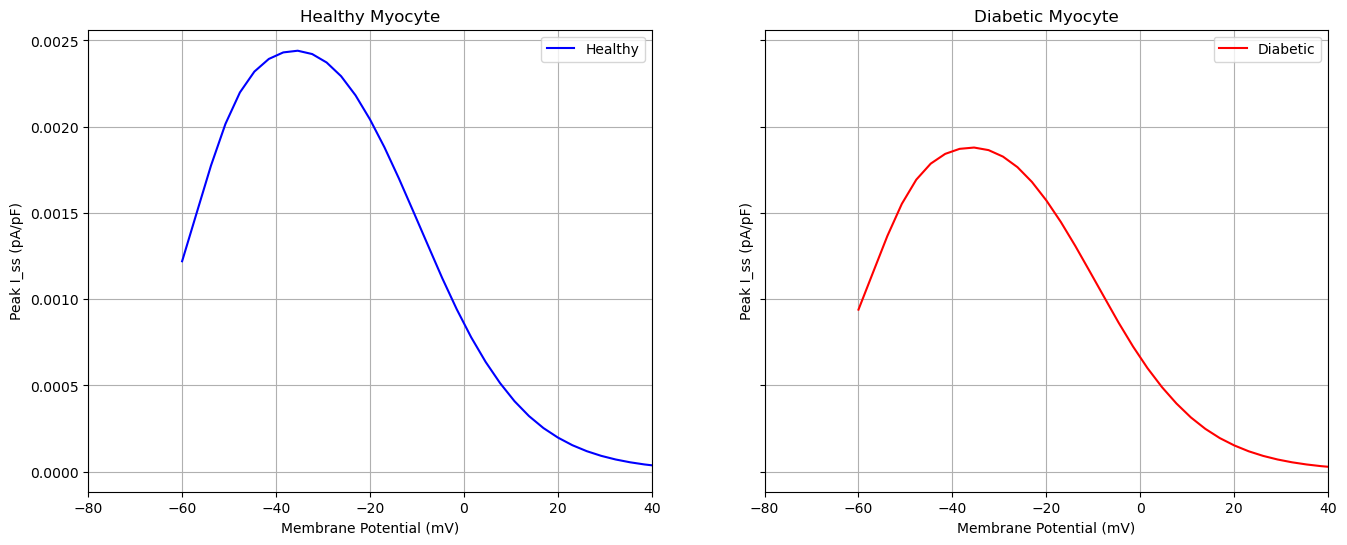

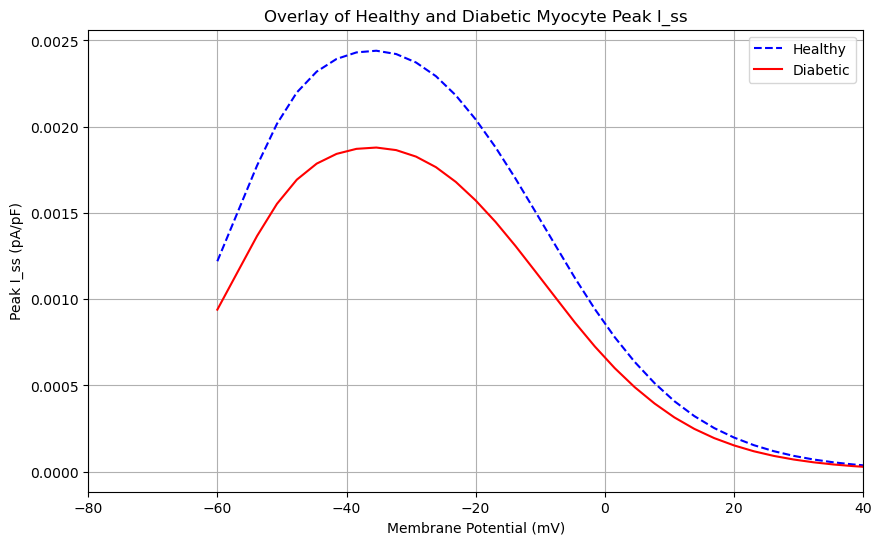

In [7]:
# Plotting
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot healthy I_ss values
axs[0].plot(V_range, normalised_healthy_i_ss, label='Healthy', color='blue')
axs[0].set_xlim(-80, 40)
axs[0].set_xlabel('Membrane Potential (mV)')
axs[0].set_ylabel('Peak I_ss (pA/pF)')
axs[0].set_title('Healthy Myocyte')
axs[0].legend()
axs[0].grid(True)

# Plot diabetic I_ss values
axs[1].plot(V_range, normalised_diabetic_i_ss, label='Diabetic', color='red')
axs[1].set_xlim(-80, 40)
axs[1].set_xlabel('Membrane Potential (mV)')
axs[1].set_ylabel('Peak I_ss (pA/pF)')
axs[1].set_title('Diabetic Myocyte')
axs[1].legend()
axs[1].grid(True)

# Overlay plot
plt.figure(figsize=(10, 6))
plt.plot(V_range, normalised_healthy_i_ss, label='Healthy', color='blue', linestyle='--')
plt.plot(V_range, normalised_diabetic_i_ss, label='Diabetic', color='red')
plt.xlim(-80, 40)
plt.xlabel('Membrane Potential (mV)')
plt.ylabel('Peak I_ss (pA/pF)')
plt.title('Overlay of Healthy and Diabetic Myocyte Peak I_ss')
plt.legend()
plt.grid(True)
plt.show()